# Лабораторная работа 4: Деревья. Случайный лес

## Часть 1: Основы построения решающие дерева

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
entropy=-(0.8*np.log(0.8)+0.2*np.log(0.2))
print("Энтропия = ",round(entropy,2))

Энтропия =  0.5


**Задание 1.2** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
def h(p1,p2):
  return p1*(1.0-p1)+p2*(1.0-p2)

Q=h(0.8,0.2)-0.8*h(1.0,0.0)-0.2*h(0.0,1.0)
print("Критерий информативности = ",round(Q,2))

Критерий информативности =  0.32


**Задание 1.3** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
list=[1,10,5,18,100,30,50,61,84,47]
avglist=np.mean(list)
print("Предсказания модели = ",avglist)

Предсказания модели =  40.6


## Часть 2: Решающие деревья

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

Входные параметры функции:
- feature_vector - вектор значений признака
- target_vector - вектор целевых значений
- task - тип задачи: "classification" (классификация)
- feature_type - тип признака: "real" (непрерывный)

Локальные переменные внутри функции:

Для обработки данных:
- X - преобразованный в numpy array вектор признаков
- y - преобразованный в numpy array вектор целевых значений
- n - количество элементов в выборке
- unique_vals - уникальные значения признака (для continuous признаков)
- thresholds - пороговые значения для разбиения
- mask - булев маска для разделения выборки

Для поддеревьев:
- left_y - целевые значения в левом поддереве (<= threshold или == для категориального)
- right_y - целевые значения в правом поддереве

Для классификации:
- classes - уникальные классы в целевой переменной
- counts - количество объектов каждого класса
- class1, class2 - два наиболее частых класса
- p1, p2 - вероятности классов в всей выборке
- left_p1, left_p2 - вероятности классов в левом поддереве
- right_p1, right_p2 - вероятности классов в правом поддереве
- H_R - индекс Джини

Для регрессии:
- total_var - дисперсия всей выборки
- left_var - дисперсия левого поддерева
- right_var - дисперсия правого поддерева

Для оценки качества разбиения:
- Q - значение критерия информативности (gain)
- best_idx - индекс лучшего порога
- criteria - список значений критерия информативности для каждого порога

Функции в find_best_split:

Встроенные функции numpy:
- np.array() - преобразование данных в numpy массивы
- np.unique() - получение уникальных значений
- np.mean() - вычисление среднего (вероятностей классов)
- np.var() - вычисление дисперсии (для регрессии)
- np.bincount() - подсчет количества объектов каждого класса
- np.argsort() - получение индексов отсортированного массива (для поиска двух самых частых классов)
- np.all() - проверка условия для всех элементов массива
- np.argmax() - поиск индекса максимального элемента (лучшего критерия)

Логические операции:
- X <= threshold / X == threshold - создание масок для разделения выборки
- ~mask - инверсия маски (получение правого поддерева)

Процесс работы функции:
- Подготовка данных (преобразование в numpy массивы)
- Генерация порогов:
  - Для continuous: средние между соседними уникальными значениями
  - Для категориальных: все уникальные значения
- Оценка каждого порога:
  - Разделение выборки на левое/правое поддеревья
  - Вычисление критерия информативности (Gini gain или Variance reduction)
- Выбор лучшего порога (максимальное значение критерия)
- Возврат результатов (пороги, критерии, лучший порог и его значение)

In [ ]:
def find_best_split(feature_vector, target_vector, task="classification", feature_type="real"):
    X = np.array(feature_vector)
    y = np.array(target_vector)
    n = len(X)

    if n == 0:
        return np.array([]), np.array([]), -np.inf, -np.inf


    if feature_type == "real":
        unique_vals = np.unique(X)
        if len(unique_vals) <= 1:
            return np.array([]), np.array([]), -np.inf, -np.inf
        thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2
    else:
        thresholds = np.unique(X)
        if len(thresholds) <= 1:
            return np.array([]), np.array([]), -np.inf, -np.inf

    criteria = []

    for threshold in thresholds:

        if feature_type == "real":
            mask = X <= threshold
        else:
            mask = X == threshold

        left_y = y[mask]
        right_y = y[~mask]

        if len(left_y) == 0 or len(right_y) == 0:
            criteria.append(-np.inf)
            continue

        if task == "classification":
            classes = np.unique(y)
            if len(classes) > 2:
                counts = np.bincount(y.astype(int))
                class1, class2 = np.argsort(counts)[-2:]
            else:
                class1, class2 = classes[0], classes[1] if len(classes) > 1 else classes[0]

            p1 = np.mean(y == class1)
            p2 = np.mean(y == class2)
            H_R = h(p1, p2)

            left_p1 = np.mean(left_y == class1)
            left_p2 = np.mean(left_y == class2)

            right_p1 = np.mean(right_y == class1)
            right_p2 = np.mean(right_y == class2)

            Q = H_R - (len(left_y)/n * h(left_p1, left_p2) + len(right_y)/n * h(right_p1, right_p2))
            criteria.append(Q)
        else:
            left_var = np.var(left_y)
            right_var = np.var(right_y)
            total_var = np.var(y)

            Q = total_var - (len(left_y)/n * left_var + len(right_y)/n * right_var)
            criteria.append(Q)

    criteria = np.array(criteria)

    if np.all(criteria == -np.inf):
        return thresholds, criteria, -np.inf, -np.inf

    best_idx = np.argmax(criteria)
    return thresholds, criteria, thresholds[best_idx], criteria[best_idx]

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

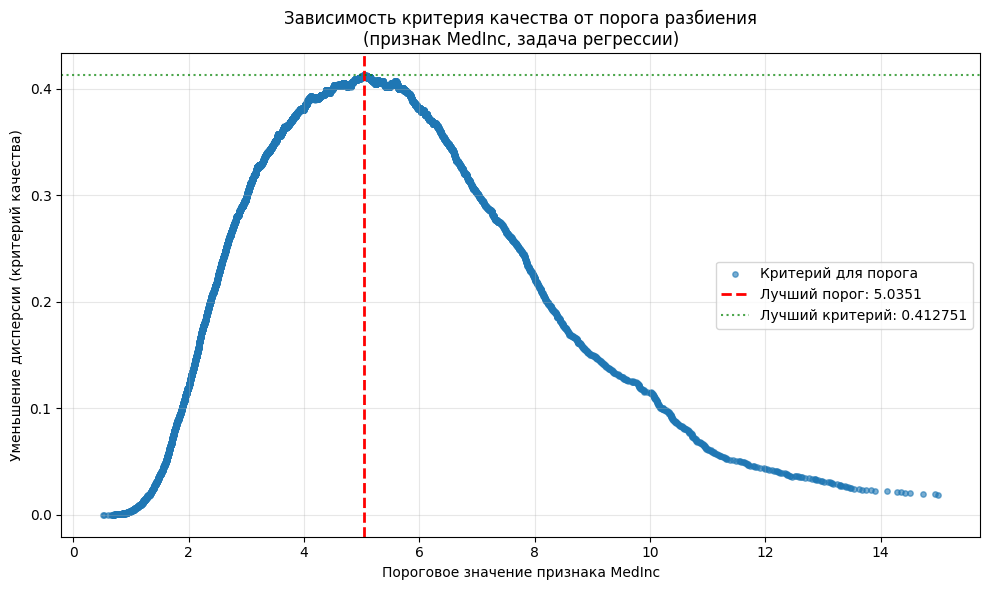

In [ ]:
thresholds, criteria, best_threshold, best_criterion = find_best_split(
    feature_vector=X['MedInc'],
    target_vector=y,
    task="regression",
    feature_type="real"
)

plt.figure(figsize=(10, 6))
plt.scatter(thresholds, criteria, alpha=0.6, s=15, label='Критерий для порога')
plt.axvline(x=best_threshold, color='red', linestyle='--',
            label=f'Лучший порог: {best_threshold:.4f}', linewidth=2)
plt.axhline(y=best_criterion, color='green', linestyle=':',
            label=f'Лучший критерий: {best_criterion:.6f}', alpha=0.7)

plt.xlabel('Пороговое значение признака MedInc')
plt.ylabel('Уменьшение дисперсии (критерий качества)')
plt.title('Зависимость критерия качества от порога разбиения\n(признак MedInc, задача регрессии)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

Алгоритм поиска:
- Инициализируем переменные, начинаем с худших значений (критерий стремится к минус бесконечности best_criterion = -np.inf)
- Перебираем все признаки в цикле for feature in X.columns:
- Ищем лучший порог для каждого признака
  - Для каждого признака вызывается функция find_best_split, которая генерирует все возможные пороги, вычисляет максимальный gain или максимальное уменьшение дисперсии для регрессии (criterion_best)
- Выбирается признак и порог, которые дают максимальное улучшение качества

Лучший признак: MedInc
Лучший порог: 5.03515
Лучший критерий: 0.41275138620167695


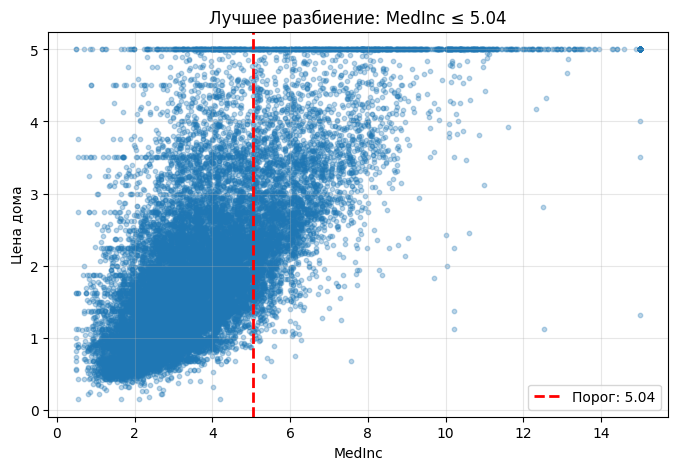

In [ ]:
best_feature = None
best_criterion = -np.inf
best_threshold = None

for feature in X.columns:
    thresholds, criteria, threshold_best, criterion_best = find_best_split(
        feature_vector=X[feature],
        target_vector=y,
        task="regression",
        feature_type="real"
    )

    if criterion_best > best_criterion and not np.isinf(criterion_best):
        best_criterion = criterion_best
        best_threshold = threshold_best
        best_feature = feature

print(f"Лучший признак: {best_feature}")
print(f"Лучший порог: {best_threshold}")
print(f"Лучший критерий: {best_criterion}")

plt.figure(figsize=(8, 5))
plt.scatter(X[best_feature], y, alpha=0.3, s=10)
plt.axvline(x=best_threshold, color='red', linestyle='--',
            linewidth=2, label=f'Порог: {best_threshold:.2f}')
plt.xlabel(best_feature)
plt.ylabel('Цена дома')
plt.title(f'Лучшее разбиение: {best_feature} ≤ {best_threshold:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Задание 2.2** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

Функция _predict_node() проходится по уже построенному дереву решений для предсказания класса для одного объекта

Работа алгоритма:
- Начинаем с корня дерева
- Ищем узел с типом terminal
- проверяем тип узла(если terminal - возвращаем предсказание, если нет - идем в поддерево)


In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")
        self._tree = {}

        self._feature_types = feature_types

        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
          return node["class"]

        feature_idx = node["feature_split"]

        if self._feature_types[feature_idx] == "real":
            if x[feature_idx] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

        elif self._feature_types[feature_idx] == "categorical":
            if x[feature_idx] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

Переменные для загрузки и подготовки данных:

Загрузка данных:
- df - DataFrame с данными из CSV-файла 'students.csv'
- unnamed_cols - список столбцов, содержащих 'unnamed' в названии (чтобы их убрать)
- X - матрица признаков (все столбцы, кроме последнего)
- y - вектор целевой переменной (последний столбец)

Функции и методы:
- X.columns.tolist() - список названий признаков
- y.name - название целевой переменной
- y.value_counts() - распределение классов

Функции для вычисления критериев:
- calculate_gini(targets) - вычисление индекса джини (targets - вектор целевых значений (меток классов))
    Локальные переменные:
    - classes - уникальные классы
    - counts - количество объектов каждого класса
    - probs - вероятности (доли) каждого класса

- calculate_gini_curve(feature_vector, target_vector) - вычисление кривой "порог-выигрыш" (feature_vector - значения одного признака, target_vector - целевые значения). Возвращает массивы порогов и соответствующих выигрышей
    - Локальные переменные:
        - X, y - numpy массивы входных данных
        - sorted_indices - индексы для сортировки признака по возрастанию
        - X_sorted, y_sorted - отсортированные данные
        - unique_X - уникальные значения признака
        - potential_thresholds - потенциальные пороги (средние между соседними уникальными значениями)
        - thresholds, gains - списки порогов и соответствующих значений выигрыша
        - parent_gini - индекс джини всей выборки (до разбиения)
    - Внутри цикла:
        - threshold - текущий рассматриваемый порог
        - left_mask, right_mask - булевы маски для разделения выборки
        - y_left, y_right - целевые значения в левом и правом поддеревьях
        - gini_left, gini_right - индексы джини поддеревьев
        - n_total - общее количество объектов
        - weighted_gini - взвешенная джини после разбиения
        - gain - информационный выигрыш (уменьшение неоднородности)


Признаки: ['STG', 'SCG', 'STR', 'LPR', 'PEG']
Целевая переменная: UNS
Распределение классов:
UNS
1    151
0    107
Name: count, dtype: int64


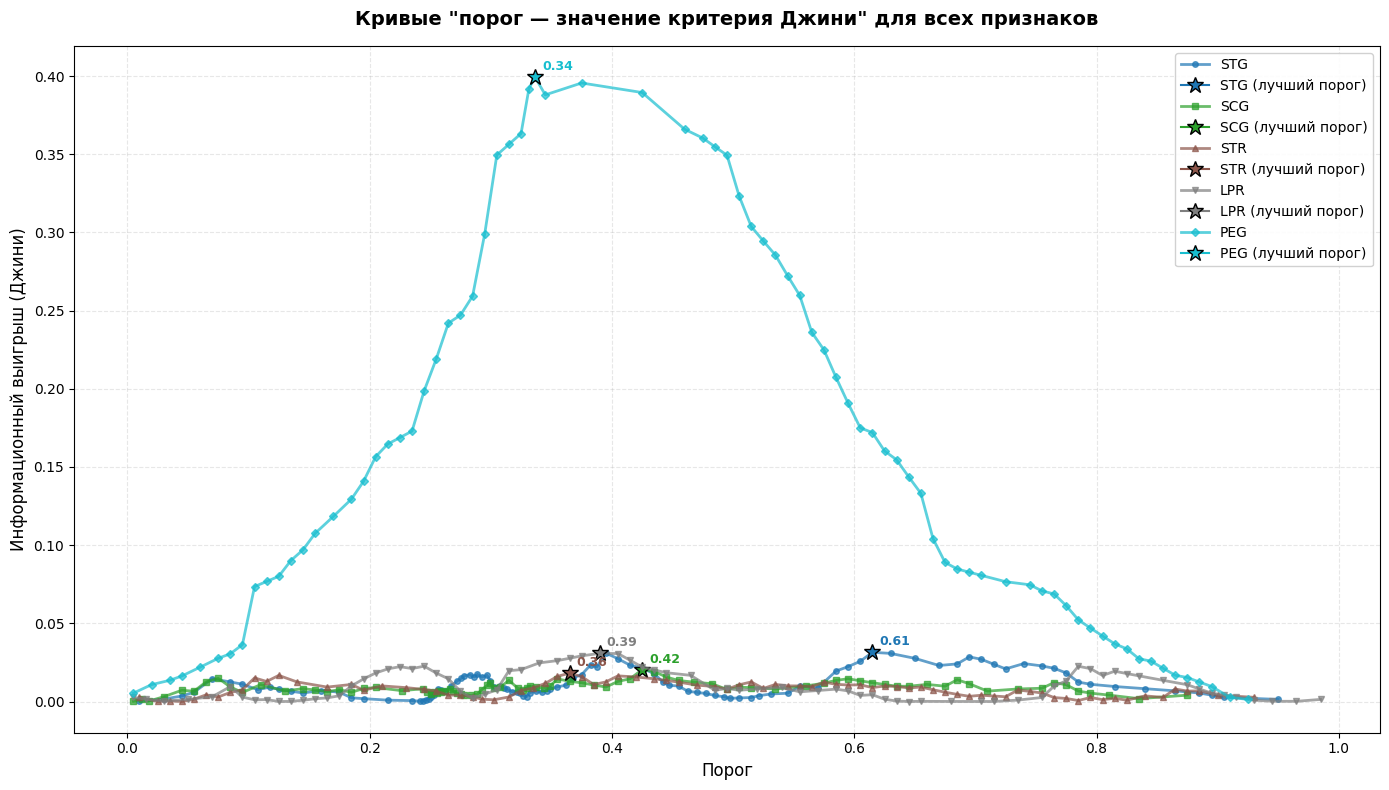

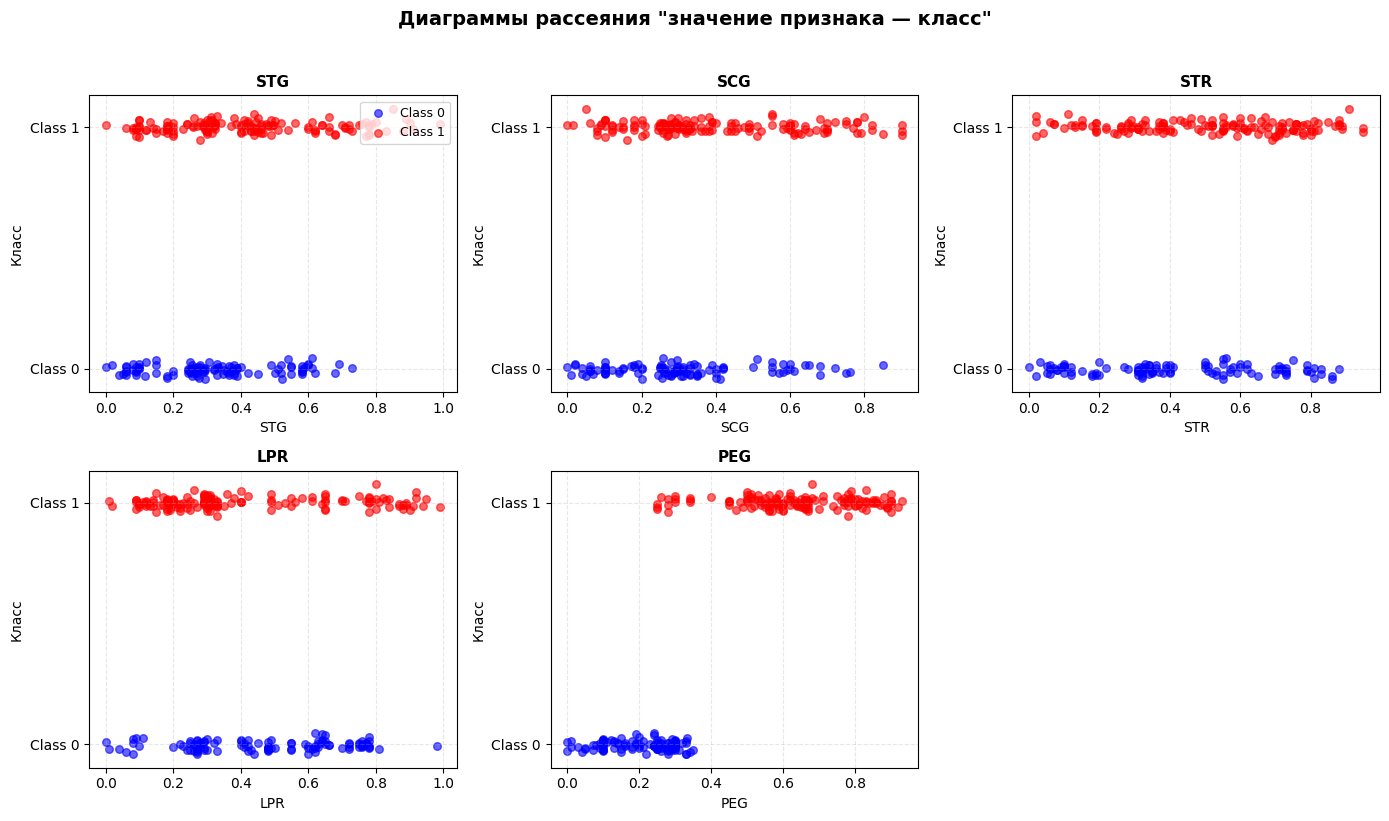

In [4]:
df = pd.read_csv('students.csv')

unnamed_cols = [col for col in df.columns if 'unnamed' in col.lower()]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(f"\nПризнаки: {X.columns.tolist()}")
print(f"Целевая переменная: {y.name}")
print(f"Распределение классов:\n{y.value_counts()}")

def calculate_gini(targets):
    if len(targets) == 0:
        return 0
    classes, counts = np.unique(targets, return_counts=True)
    probs = counts / len(targets)
    return 1 - np.sum(probs ** 2)

def calculate_gini_curve(feature_vector, target_vector):
    X = np.array(feature_vector)
    y = np.array(target_vector)

    sorted_indices = np.argsort(X)
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]

    unique_X = np.unique(X_sorted)
    if len(unique_X) <= 1:
        return np.array([]), np.array([])

    potential_thresholds = (unique_X[:-1] + unique_X[1:]) / 2

    thresholds = []
    gains = []

    parent_gini = calculate_gini(y)

    for threshold in potential_thresholds:
        left_mask = X_sorted <= threshold
        right_mask = X_sorted > threshold

        y_left = y_sorted[left_mask]
        y_right = y_sorted[right_mask]

        if len(y_left) == 0 or len(y_right) == 0:
            continue

        gini_left = calculate_gini(y_left)
        gini_right = calculate_gini(y_right)

        n_total = len(y)
        weighted_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / n_total

        gain = parent_gini - weighted_gini

        thresholds.append(threshold)
        gains.append(gain)

    return np.array(thresholds), np.array(gains)

plt.figure(figsize=(14, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(X.columns)))
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h']

for idx, (feature_name, color, marker) in enumerate(zip(X.columns, colors, markers)):
    feature_values = X[feature_name].values
    thresholds, gains = calculate_gini_curve(feature_values, y.values)

    if len(thresholds) > 0:
        plt.plot(thresholds, gains, color=color, linewidth=2,
                label=feature_name, marker=marker, markersize=4, alpha=0.7)

        best_idx = np.argmax(gains)
        best_threshold = thresholds[best_idx]
        best_gain = gains[best_idx]

        plt.plot(best_threshold, best_gain, marker='*',
                color=color, markersize=12, markeredgecolor='black',
                markeredgewidth=1, label=f'{feature_name} (лучший порог)')

        plt.annotate(f'{best_threshold:.2f}',
                    xy=(best_threshold, best_gain),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    color=color)

plt.xlabel('Порог', fontsize=12)
plt.ylabel('Информационный выигрыш (Джини)', fontsize=12)
plt.title('Кривые "порог — значение критерия Джини" для всех признаков',
          fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(14, 8))

n_features = len(X.columns)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

for i, feature_name in enumerate(X.columns, 1):
    ax = plt.subplot(n_rows, n_cols, i)

    feature_values = X[feature_name].values

    class_0_mask = y == 0
    class_1_mask = y == 1

    np.random.seed(42)
    jitter = np.random.normal(0, 0.02, len(y))

    ax.scatter(feature_values[class_0_mask],
               y[class_0_mask] + jitter[class_0_mask],
               alpha=0.6, color='blue', label='Class 0', s=30)

    ax.scatter(feature_values[class_1_mask],
               y[class_1_mask] + jitter[class_1_mask],
               alpha=0.6, color='red', label='Class 1', s=30)

    ax.set_xlabel(feature_name, fontsize=10)
    ax.set_ylabel('Класс', fontsize=10)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Class 0', 'Class 1'])
    ax.set_title(f'{feature_name}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')

    if i == 1:
        ax.legend(loc='upper right', fontsize=9)

plt.suptitle('Диаграммы рассеяния "значение признака — класс"',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


**ВОПРОСЫ: Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?**

Лучшим признаком является PEG, так как у него максимальный выигрыш - 0,3994. Этот результат согласуется с визуальной оценкой диграммы рассеивания, класс 0 в основном сосредоточен ниже 0,34, а класс 1 - выше. У остальных признаков наблюдается перекрытие классов, что затрудняет разделение.

Характеристики хороших признаков: Кривая имеет ярко выраженный максимум, у критерия видно резкий подъем и спад,значительная разница между минимальным и максимальным значением

Характеристики кривых для признаков, по которым деление практически невозможно, прямо противоположны признакам хороших признаков

**Задание 2.4** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (находится в директории с ноутбуком),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

Переменные для преобразования данных:
- label_encoders - словарь для хранения энкодеров каждого столбца
- df_encoded - копия DataFrame с закодированными значениями
- col - текущий столбец в цикле
- le - объект LabelEncoder для текущего столбца

Функции и методы:
- LabelEncoder() - кодирование категориальных признаков в числовые
- le.fit_transform() - обучение и преобразование за один шаг

Создание и обучение модели:
- model - объект модели дерева решений
- DecisionTreeClassifier() - класс модели из scikit-learn
- random_state=42 - фиксация случайности для воспроизводимости
- model.fit(X_train, y_train) - обучение модели на обучающей выборке

Предсказания и оценка:
- y_pred - предсказанные моделью значения для тестовой выборки
- model.predict(X_test) - метод предсказания модели
- accuracy - точность модели
- accuracy_score(y_test, y_pred) - вычисление accuracy

In [ ]:
df = pd.read_csv('agaricus-lepiota.data', header=None)

label_encoders = {}
df_encoded = df.copy()

for col in df.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df_encoded.iloc[:, 1:]
y = df_encoded.iloc[:, 0]

print(f"Распределение классов: edible={np.sum(y==0)}, poisonous={np.sum(y==1)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмеры выборок:")
print(f"Обучающая: {X_train.shape[0]} объектов, {X_train.shape[1]} признака")
print(f"Тестовая: {X_test.shape[0]} объектов")

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nРезультат:")
print(f"Accuracy на тестовой выборке: {accuracy:.4f} ({accuracy:.2%})")

Распределение классов: edible=4208, poisonous=3916

Размеры выборок:
Обучающая: 6499 объектов, 22 признака
Тестовая: 1625 объектов

Результат:
Accuracy на тестовой выборке: 1.0000 (100.00%)


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

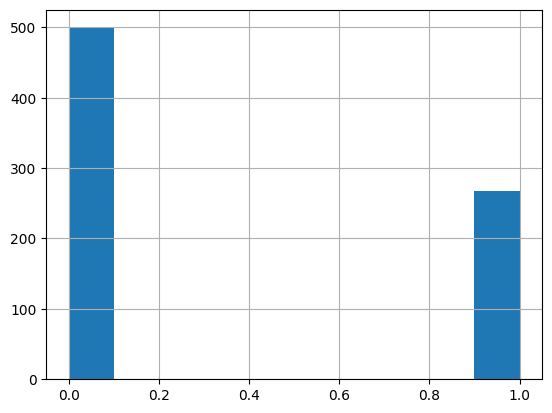

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42
)

print("Размеры выборок:")
print(f"Обучающая-обучающая: {X_train.shape[0]} строк ({X_train.shape[0]/len(data):.1%} от исходного датасета)")
print(f"Обучающая-валидационная: {X_val.shape[0]} строк ({X_val.shape[0]/len(data):.1%} от исходного датасета)")
print(f"Тестовая: {X_test.shape[0]} строк ({X_test.shape[0]/len(data):.1%} от исходного датасета)")
print(f"Всего: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} строк")


Размеры выборок:
Обучающая-обучающая: 375 строк (48.8% от исходного датасета)
Обучающая-валидационная: 162 строк (21.1% от исходного датасета)
Тестовая: 231 строк (30.1% от исходного датасета)
Всего: 768 строк


**Задание 3.2** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

- max_depth_values - значения для максимальной глубины дерева
- min_samples_leaf_values - значения для минимального количества образцов в листе
- best_f1 - лучшее значение F1-score (инициализировано 0)
- best_params - словарь с лучшими параметрами
- all_classes - все уникальные классы из train/val/test
- n_classes - количество уникальных классов
- avg_method - метод усреднения для многоклассовой классификации ('binary' для 2 классов, 'weighted' для >2 классов)
- y_val_pred - предсказания на валидационной выборке
- y_test_pred - предсказания на тестовой выборке
- y_test_proba - вероятности предсказаний на тесте
- np.unique() - получение уникальных значений
- np.concatenate() - объединение массивов
- np.where() - поиск индексов по условию
- np.mean() - вычисление среднего значения
- f1_score() - вычисление F1-score
- average - метод усреднения (binary/weighted)
- accuracy_score() - вычисление accuracy
- precision_score() - вычисление precision
- zero_division=0 - обработка случаев деления на 0
- recall_score() - вычисление recall
- roc_auc_score() - вычисление AUC-ROC
- DecisionTreeClassifier() - создание модели
- model.fit() - обучение модели
- model.predict() - предсказание классов
- model.predict_proba() - предсказание вероятностей классов
- model.get_depth() - получение глубины дерева
- model.get_n_leaves() - получение количества листьев
- model.classes_ - атрибут с классами, которые видела модель
- LabelBinarizer() - преобразование меток в бинарный формат (для многоклассового AUC-ROC)
- lb.fit() - обучение бинаризатора
- lb.transform() - преобразование меток
- lb.classes_ - доступные классы

Порядок алгоритма:
- анализ данных (определение количества классов, выбор метода усреднения метрик)
- Поиск гиперпараметров (перебор всех гиперпараметров, оценка каждой модели по F1-score, выбор лучших гиперпараметров)
- обучение финальной модели, используя лучшие гиперпараметры

In [ ]:
max_depth_values = [3, 5, 7, 10, 15, 20, None]
min_samples_leaf_values = [1, 2, 3, 5, 7, 10, 15, 20]

all_classes = np.unique(np.concatenate([y_train, y_val, y_test]))
n_classes = len(all_classes)
avg_method = 'binary' if n_classes == 2 else 'weighted'

print(f"Всего уникальных классов: {n_classes}")

best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_val_pred, average=avg_method)

        if f1 > best_f1:
            best_f1 = f1
            best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

        print(f"Глубина дерева (max) = {str(max_depth):2}, Количество листьев (min) = {min_samples_leaf:2}, F1 = {f1:.4f}")

print(f"\nЛучшие параметры: {best_params}")
print(f"Лучший F1: {best_f1:.4f}")

X_train_full = np.concatenate([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

final_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
final_model.fit(X_train_full, y_train_full)

y_test_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average=avg_method, zero_division=0)
recall = recall_score(y_test, y_test_pred, average=avg_method, zero_division=0)

if n_classes == 2:
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_test_proba)
else:
    lb = LabelBinarizer()
    lb.fit(all_classes)
    y_test_bin = lb.transform(y_test)

    y_test_proba = final_model.predict_proba(X_test)

    auc_scores = []
    n_test_classes = len(final_model.classes_)

    for i in range(n_test_classes):
        class_label = final_model.classes_[i]
        if class_label in y_test:
            class_idx = np.where(lb.classes_ == class_label)[0][0]
            if len(np.unique(y_test_bin[:, class_idx])) > 1:
                auc_class = roc_auc_score(y_test_bin[:, class_idx], y_test_proba[:, i])
                auc_scores.append(auc_class)

    if auc_scores:
        auc_roc = np.mean(auc_scores)
    else:
        auc_roc = 0.5

print("\nРезультаты:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC-ROC:   {auc_roc:.4f}")
print(f"\nГлубина дерева: {final_model.get_depth()}")
print(f"Количество листьев: {final_model.get_n_leaves()}")

Всего уникальных классов: 17
Глубина дерева (max) = 3 , Количество листьев (min) =  1, F1 = 0.1268
Глубина дерева (max) = 3 , Количество листьев (min) =  2, F1 = 0.1268
Глубина дерева (max) = 3 , Количество листьев (min) =  3, F1 = 0.1268
Глубина дерева (max) = 3 , Количество листьев (min) =  5, F1 = 0.1268
Глубина дерева (max) = 3 , Количество листьев (min) =  7, F1 = 0.1268
Глубина дерева (max) = 3 , Количество листьев (min) = 10, F1 = 0.1268
Глубина дерева (max) = 3 , Количество листьев (min) = 15, F1 = 0.1268
Глубина дерева (max) = 3 , Количество листьев (min) = 20, F1 = 0.1191
Глубина дерева (max) = 5 , Количество листьев (min) =  1, F1 = 0.1654
Глубина дерева (max) = 5 , Количество листьев (min) =  2, F1 = 0.1837
Глубина дерева (max) = 5 , Количество листьев (min) =  3, F1 = 0.2019
Глубина дерева (max) = 5 , Количество листьев (min) =  5, F1 = 0.1975
Глубина дерева (max) = 5 , Количество листьев (min) =  7, F1 = 0.1823
Глубина дерева (max) = 5 , Количество листьев (min) = 10, F1 

**Задание 3.3** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

- bagging_model - объект модели бэггинга
- BaggingClassifier() - конструктор ансамблевой модели бэггинга
- estimator=DecisionTreeClassifier(random_state=42) - базовый классификатор (дерево решений)
- n_estimators=50 - количество деревьев в ансамбле
- random_state=42 - фиксация случайности для воспроизводимости
- bagging_model.fit(X, y) - обучение модели на данных
- bagging_model.predict(X) - предсказание классов
- bagging_model.predict_proba(X) - предсказание вероятностей классов
- bagging_model.classes_ - атрибут со списком классов, которые видела модель

Параметры BaggingClassifier:
- n_estimators=50 - 50 деревьев в ансамбле
- estimator - тип базового классификатора (дерево решений)
- random_state - воспроизводимость случайных подвыборок

Порядок алгоритма:
- Создание и обучение модели
- Предсказание на тестовой выборке
- Анализ количества классов
- Вычисление базовых метрик и AUC-ROC

In [ ]:
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    random_state=42
)

bagging_model.fit(X_train_full, y_train_full)

y_test_pred = bagging_model.predict(X_test)

n_classes = len(np.unique(y_train_full))
avg_method = 'binary' if n_classes == 2 else 'weighted'

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average=avg_method, zero_division=0)
recall = recall_score(y_test, y_test_pred, average=avg_method, zero_division=0)

y_test_proba = bagging_model.predict_proba(X_test)

if n_classes == 2:
    auc_roc = roc_auc_score(y_test, y_test_proba[:, 1])
else:
    classes_in_model = bagging_model.classes_

    from sklearn.preprocessing import label_binarize

    y_test_bin = label_binarize(y_test, classes=classes_in_model)

    auc_scores = []
    for i, class_label in enumerate(classes_in_model):
        if class_label in y_test:
            if len(np.unique(y_test_bin[:, i])) > 1:
                auc_class = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])
                auc_scores.append(auc_class)

    auc_roc = np.mean(auc_scores) if auc_scores else 0.5

print("Результаты:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC-ROC:   {auc_roc:.4f}")

Результаты:
Accuracy:  0.2208
Precision: 0.2330
Recall:    0.2208
AUC-ROC:   0.6539


**Задание 3.4** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
print("Подбор гиперпараметров:")

max_depth_values = [5, 10, 15, None]
min_samples_split_values = [2, 5, 10]

n_classes = len(np.unique(y_train_full))
avg_method = 'binary' if n_classes == 2 else 'weighted'

best_score = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )

        scores = cross_val_score(
            rf, X_train_full, y_train_full,
            cv=5,
            scoring='f1_weighted' if avg_method == 'weighted' else 'f1'
        )

        mean_score = np.mean(scores)

        if mean_score > best_score:
            best_score = mean_score
            best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}

        print(f"Глубина дерева (max)={str(max_depth):2}, Количество листьев (min)={min_samples_split:2}, F1 = {mean_score:.4f}")

print(f"\nЛучшие параметры: {best_params}")
print(f"Лучший F1: {best_score:.4f}")

final_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

final_rf.fit(X_train_full, y_train_full)

y_test_pred = final_rf.predict(X_test)
y_test_proba = final_rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average=avg_method, zero_division=0)
recall = recall_score(y_test, y_test_pred, average=avg_method, zero_division=0)

if n_classes == 2:
    auc_roc = roc_auc_score(y_test, y_test_proba[:, 1])
else:
    from sklearn.preprocessing import label_binarize

    all_classes = np.unique(np.concatenate([y_train_full, y_test]))
    y_test_bin = label_binarize(y_test, classes=all_classes)

    auc_scores = []
    for i in range(len(all_classes)):
        if i < y_test_proba.shape[1]:
            if len(np.unique(y_test_bin[:, i])) > 1:
                auc_class = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])
                auc_scores.append(auc_class)

    auc_roc = np.mean(auc_scores) if auc_scores else 0.5

print("\nРезультаты:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC-ROC:   {auc_roc:.4f}")

Подбор гиперпараметров:
Глубина дерева (max)=5 , Количество листьев (min)= 2, F1 = 0.1516
Глубина дерева (max)=5 , Количество листьев (min)= 5, F1 = 0.1624
Глубина дерева (max)=5 , Количество листьев (min)=10, F1 = 0.1527
Глубина дерева (max)=10, Количество листьев (min)= 2, F1 = 0.1842
Глубина дерева (max)=10, Количество листьев (min)= 5, F1 = 0.2007
Глубина дерева (max)=10, Количество листьев (min)=10, F1 = 0.1766
Глубина дерева (max)=15, Количество листьев (min)= 2, F1 = 0.1693
Глубина дерева (max)=15, Количество листьев (min)= 5, F1 = 0.1877
Глубина дерева (max)=15, Количество листьев (min)=10, F1 = 0.1862
Глубина дерева (max)=None, Количество листьев (min)= 2, F1 = 0.1722
Глубина дерева (max)=None, Количество листьев (min)= 5, F1 = 0.1899
Глубина дерева (max)=None, Количество листьев (min)=10, F1 = 0.1811

Лучшие параметры: {'max_depth': 10, 'min_samples_split': 5}
Лучший F1: 0.2007

Результаты:
Accuracy:  0.1602
Precision: 0.1676
Recall:    0.1602
AUC-ROC:   0.7085


**Задание 3.5** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

Количество деревьев:   1, AUC-ROC: 0.5150
Количество деревьев:   5, AUC-ROC: 0.5871
Количество деревьев:  10, AUC-ROC: 0.6005
Количество деревьев:  20, AUC-ROC: 0.6259
Количество деревьев:  30, AUC-ROC: 0.6326
Количество деревьев:  40, AUC-ROC: 0.6481
Количество деревьев:  50, AUC-ROC: 0.6542
Количество деревьев:  60, AUC-ROC: 0.6504
Количество деревьев:  70, AUC-ROC: 0.6584
Количество деревьев:  80, AUC-ROC: 0.6574
Количество деревьев:  90, AUC-ROC: 0.6656
Количество деревьев: 100, AUC-ROC: 0.6671


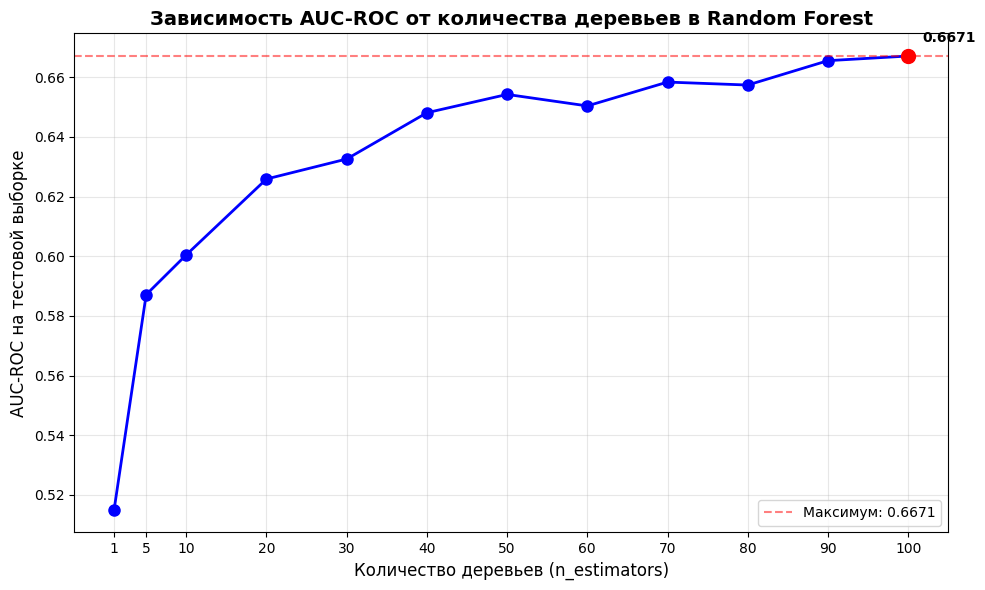


Результаты:
Оптимальное количество деревьев: 50
Максимальный AUC-ROC: 0.6671 при 100 деревьях
Улучшение от 1 до 50 деревьев: 0.1392


In [ ]:
n_classes = len(np.unique(y_train_full))

n_trees_range = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
auc_scores = []

for n_trees in n_trees_range:
    rf = RandomForestClassifier(
        n_estimators=n_trees,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_full, y_train_full)

    y_test_proba = rf.predict_proba(X_test)

    if n_classes == 2:
        auc = roc_auc_score(y_test, y_test_proba[:, 1])
    else:
        all_classes = np.unique(np.concatenate([y_train_full, y_test]))
        y_test_bin = label_binarize(y_test, classes=all_classes)

        tree_auc_scores = []
        for i in range(len(all_classes)):
            if i < y_test_proba.shape[1]:
                if len(np.unique(y_test_bin[:, i])) > 1:
                    auc_class = roc_auc_score(y_test_bin[:, i], y_test_proba[:, i])
                    tree_auc_scores.append(auc_class)

        auc = np.mean(tree_auc_scores) if tree_auc_scores else 0.5

    auc_scores.append(auc)
    print(f"Количество деревьев: {n_trees:3}, AUC-ROC: {auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_trees_range, auc_scores, 'b-o', linewidth=2, markersize=8)
plt.title('Зависимость AUC-ROC от количества деревьев в Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Количество деревьев (n_estimators)', fontsize=12)
plt.ylabel('AUC-ROC на тестовой выборке', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(n_trees_range)

max_auc = max(auc_scores)
max_auc_idx = auc_scores.index(max_auc)
plt.axhline(y=max_auc, color='r', linestyle='--', alpha=0.5, label=f'Максимум: {max_auc:.4f}')

plt.plot(n_trees_range[max_auc_idx], max_auc, 'ro', markersize=10)
plt.annotate(f'{max_auc:.4f}',
             xy=(n_trees_range[max_auc_idx], max_auc),
             xytext=(10, 10), textcoords='offset points',
             fontsize=10, fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

threshold = 0.001
optimal_trees = n_trees_range[0]
max_auc_reached = auc_scores[0]

for i in range(1, len(n_trees_range)):
    improvement = auc_scores[i] - max_auc_reached
    if improvement > threshold:
        max_auc_reached = auc_scores[i]
        optimal_trees = n_trees_range[i]
    else:
        break
print("\nРезультаты:")
print(f"Оптимальное количество деревьев: {optimal_trees}")
print(f"Максимальный AUC-ROC: {max(auc_scores):.4f} при {n_trees_range[auc_scores.index(max(auc_scores))]} деревьях")
print(f"Улучшение от 1 до {optimal_trees} деревьев: {max_auc_reached - auc_scores[0]:.4f}")

Выводы:
С ростом количества деревьев AUC-ROC обычно увеличивается;
После определенного количества деревьев прирост качества замедляется;
Оптимальное количество деревьев зависит от сложности задачи;
Слишком большое количество деревьев может привести к длительному времени обучения,незначительному улучшению качества, потреблению большего объема памяти.

**Задание 3.6** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?


Важность признаков для предсказания диабета:
 1. DiabetesPedigreeFunction      : 0.1728
 2. BMI                           : 0.1607
 3. Insulin                       : 0.1572
 4. Pregnancies                   : 0.1526
 5. Glucose                       : 0.1333
 6. BloodPressure                 : 0.1069
 7. SkinThickness                 : 0.0876
 8. Age                           : 0.0290


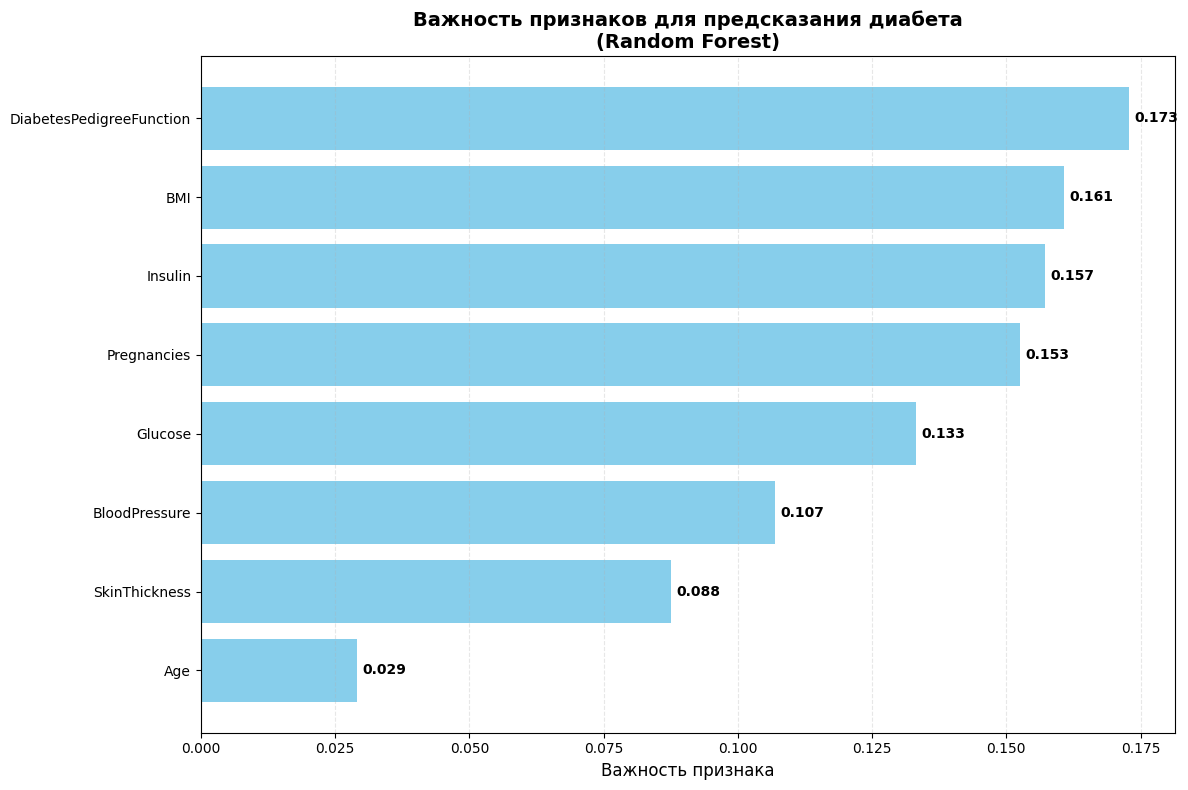


Результаты:
Самый важный признак: DiabetesPedigreeFunction
Его важность: 0.1728
Доля важности: 17.3% от общей важности


In [ ]:
rf_best = RandomForestClassifier(
    n_estimators=50,
    random_state=42
)

rf_best.fit(X_train_full, y_train_full)

feature_importances = rf_best.feature_importances_

feature_names = [
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI',
    'DiabetesPedigreeFunction',
    'Age'
]

if len(feature_importances) != len(feature_names):
    print(f"Внимание: Количество признаков в модели ({len(feature_importances)}) не совпадает с ожидаемым ({len(feature_names)})")

    feature_names = [f'Признак {i}' for i in range(len(feature_importances))]

sorted_idx = np.argsort(feature_importances)[::-1]

print("\nВажность признаков для предсказания диабета:")

for i, idx in enumerate(sorted_idx):
    print(f"{i+1:2}. {feature_names[idx]:<30}: {feature_importances[idx]:.4f}")

plt.figure(figsize=(12, 8))

n_top = len(feature_importances)
top_features = [feature_names[idx] for idx in sorted_idx[:n_top]]
top_importances = feature_importances[sorted_idx[:n_top]]

bars = plt.barh(range(n_top), top_importances, color='skyblue')
plt.yticks(range(n_top), top_features, fontsize=10)
plt.xlabel('Важность признака', fontsize=12)
plt.title('Важность признаков для предсказания диабета\n(Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()


for i, (bar, importance) in enumerate(zip(bars, top_importances)):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{importance:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')


plt.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


most_important = feature_names[sorted_idx[0]]
most_important_importance = feature_importances[sorted_idx[0]]

print("\nРезультаты:")
print(f"Самый важный признак: {most_important}")
print(f"Его важность: {most_important_importance:.4f}")
print(f"Доля важности: {most_important_importance*100:.1f}% от общей важности")
